## Section A: Imports

In [81]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from src.features.technical import build_feature_matrix
from src.models.baseline import make_baseline_pipeline, evaluate_model
from src.models.ensemble import train_random_forest, train_xgboost, evaluate_ensemble
from src.eval.metrics import (
    compute_equity_curve,
    compute_sharpe_ratio,
    compute_max_drawdown,
    get_strategy_returns,
    )

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## Section B: Load raw SPY data

In [82]:
# Load raw data (skip header row with ticker symbols)
df_raw = pd.read_csv('../data/raw/SPY_daily.csv', skiprows=[1])

# Rename columns properly (first column is index/date, then Adj Close, Close, High, Low, Open, Volume)
df_raw.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert numeric columns to float
for col in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Parse date and set as index
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw = df_raw.set_index('Date').sort_index()

# Compute daily returns (self-contained)
df_raw['daily_ret'] = df_raw['Adj Close'].pct_change()

print(f"Data shape: {df_raw.shape}")
print(f"Date range: {df_raw.index.min()} to {df_raw.index.max()}")
df_raw.head()

Data shape: (4017, 7)
Date range: 2010-01-04 00:00:00 to 2025-12-19 00:00:00


,Adj Close,Close,High,Low,Open,Volume,daily_ret
Date,,,,,,,
2010-01-04,85.027962,113.330002,113.389999,111.510002,112.370003,118944600,NaN
2010-01-05,85.253029,113.629997,113.680000,112.849998,113.260002,111579900,0.002647
2010-01-06,85.313049,113.709999,113.989998,113.430000,113.519997,116074400,0.000704
2010-01-07,85.673203,114.190002,114.330002,113.180000,113.500000,131091100,0.004222
2010-01-08,85.958267,114.570000,114.620003,113.660004,113.889999,126402800,0.003327


## Section C: Build technical feature matrix

In [83]:
# Build feature matrix with technical indicators
df_features = build_feature_matrix(df_raw.copy())

print(f"Feature matrix shape: {df_features.shape}")
print(f"Number of features: {len(df_features.columns)}")
print(f"Date range after dropping NaNs: {df_features.index.min()} to {df_features.index.max()}")
df_features.head()

Feature matrix shape: (3997, 26)
Number of features: 26
Date range after dropping NaNs: 2010-02-02 00:00:00 to 2025-12-19 00:00:00


,Adj Close,Close,High,Low,Open,Volume,daily_ret,ret_lag_1,ret_lag_2,ret_lag_5,ret_lag_10,ret_roll_mean_5,ret_roll_std_5,ret_roll_mean_10,ret_roll_std_10,ret_roll_mean_20,ret_roll_std_20,ma_5,price_roll_std_5,bb_upper_5,bb_lower_5,ma_20,price_roll_std_20,bb_upper_20,bb_lower_20,rsi_14
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-02,82.814667,110.379997,110.589996,108.879997,109.260002,216327900,0.012104,0.015551,-0.010869,-0.004190,0.012496,0.002014,0.012653,-0.004068,0.012949,-0.001264,0.010585,81.813794,0.868776,83.551347,80.076241,84.099499,1.941043,87.981584,80.217414,48.244100
2010-02-03,82.402000,109.830002,110.480003,109.510002,109.879997,172730700,-0.004983,0.012104,0.015551,0.004757,-0.010169,0.000066,0.012873,-0.003550,0.012781,-0.001646,0.010574,81.813794,0.868776,83.551347,80.076241,83.956948,1.956497,87.869942,80.043954,46.098651
2010-02-04,79.858566,106.440002,109.029999,106.419998,108.980003,356715700,-0.030866,-0.004983,0.012104,-0.011472,-0.019229,-0.003813,0.018784,-0.004713,0.014746,-0.003224,0.012403,81.494174,1.245359,83.984893,79.003456,83.684224,2.129985,87.944193,79.424254,35.592595
2010-02-05,80.023643,106.660004,106.879997,104.580002,106.559998,493585800,0.002067,-0.030866,-0.004983,-0.010869,-0.022292,-0.001225,0.018457,-0.002277,0.013476,-0.003332,0.012344,81.384636,1.365148,84.114932,78.654340,83.401746,2.224834,87.851413,78.952078,36.602487
2010-02-08,79.445938,105.889999,107.330002,105.809998,106.739998,224166900,-0.007219,0.002067,-0.030866,0.015551,0.005128,-0.005780,0.015917,-0.003512,0.013287,-0.003860,0.012270,80.908963,1.572294,84.053551,77.764375,83.076129,2.306055,87.688239,78.464019,34.560188


## Section D: Define target and create X, y

For directional prediction, we create a binary classification target:
- **Predict**: Will the price go up tomorrow?
- **Label**: `target_up = 1` if next-day return > 0, else 0
- **Features**: All technical indicators (excluding the target itself)

In [84]:
# Create future return for next day
df_features['future_ret_1d'] = df_features['daily_ret'].shift(-1)

# Create binary target: 1 if future return is positive, 0 otherwise
df_features['target_up'] = (df_features['future_ret_1d'] > 0).astype(int)

# Drop rows with NaN in target (last row due to shift)
df_features = df_features.dropna(subset=['future_ret_1d'])

# Separate features and target
X = df_features.drop(columns=['target_up', 'future_ret_1d'])
y = df_features['target_up']

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nTarget proportion (up days): {y.mean():.2%}")

Feature matrix X shape: (3996, 26)
Target vector y shape: (3996,)

Target distribution:
target_up
1    2214
0    1782
Name: count, dtype: int64

Target proportion (up days): 55.41%


## Section E: Time-based train/validation/test split

**Critical for time series**: Use chronological split, never shuffle.
- **Train**: First 70% of observations
- **Validation**: Next 15% of observations
- **Test**: Final 15% of observations

In [85]:
# Calculate split indices
n = len(X)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# Create chronological splits
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Print split information
print("Split Summary:")
print(f"{'Set':<12} {'Size':<8} {'Start Date':<15} {'End Date':<15}")
print("-" * 55)
print(f"{'Train':<12} {len(X_train):<8} {X_train.index.min().strftime('%Y-%m-%d'):<15} {X_train.index.max().strftime('%Y-%m-%d'):<15}")
print(f"{'Validation':<12} {len(X_val):<8} {X_val.index.min().strftime('%Y-%m-%d'):<15} {X_val.index.max().strftime('%Y-%m-%d'):<15}")
print(f"{'Test':<12} {len(X_test):<8} {X_test.index.min().strftime('%Y-%m-%d'):<15} {X_test.index.max().strftime('%Y-%m-%d'):<15}")

Split Summary:
Set          Size     Start Date      End Date       
-------------------------------------------------------
Train        2797     2010-02-02      2021-03-12     
Validation   599      2021-03-15      2023-07-31     
Test         600      2023-08-01      2025-12-18     


## Section F: Baseline logistic regression

Train a simple logistic regression with standardized features as a baseline.
This establishes minimum expected performance for more complex models.

In [86]:
# Create pipeline with standardization and logistic regression
model = make_baseline_pipeline()

# Train model
print("Training logistic regression...")
model.fit(X_train, y_train)
print("Training complete!")

Training logistic regression...
Training complete!


In [87]:
# Evaluate baseline model on all splits
results = []
results.append(evaluate_model(model, X_train, y_train, 'Train'))
results.append(evaluate_model(model, X_val, y_val, 'Validation'))
results.append(evaluate_model(model, X_test, y_test, 'Test'))

# Display results
results_df = pd.DataFrame(results).set_index('Set')
print("\nBaseline Logistic Regression Results:")
print(results_df.round(4))


Baseline Logistic Regression Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.5720     0.5706  0.9404   0.5506
Validation    0.5159     0.5163  0.9253   0.5058
Test          0.5683     0.5744  0.9711   0.4897


## Section G: Ensemble models with time-series CV

Now we'll train more sophisticated ensemble models and compare them to the baseline.

In [88]:
# Tune Random Forest
print("Tuning Random Forest...")
rf_best, rf_cv_results = train_random_forest(X_train, y_train)

Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 400}
Best CV ROC-AUC: 0.5127


In [89]:
# Evaluate Random Forest on all splits
rf_results = []
rf_results.append(evaluate_model(rf_best, X_train, y_train, 'Train'))
rf_results.append(evaluate_model(rf_best, X_val, y_val, 'Validation'))
rf_results.append(evaluate_model(rf_best, X_test, y_test, 'Test'))

rf_results_df = pd.DataFrame(rf_results).set_index('Set')
print("\nRandom Forest Results:")
print(rf_results_df.round(4))


Random Forest Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.6618     0.6227  0.9987   0.9078
Validation    0.5175     0.5164  0.9708   0.5043
Test          0.5733     0.5781  0.9624   0.5088


In [90]:
# Tune XGBoost
print("Tuning XGBoost...")
xgb_best, xgb_cv_results = train_xgboost(X_train, y_train)

Tuning XGBoost...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV ROC-AUC: 0.5317


In [91]:
# Evaluate XGBoost on all splits
xgb_results = []
xgb_results.append(evaluate_model(xgb_best, X_train, y_train, 'Train'))
xgb_results.append(evaluate_model(xgb_best, X_val, y_val, 'Validation'))
xgb_results.append(evaluate_model(xgb_best, X_test, y_test, 'Test'))

xgb_results_df = pd.DataFrame(xgb_results).set_index('Set')
print("\nXGBoost Results:")
print(xgb_results_df.round(4))


XGBoost Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.9142     0.8819  0.9769   0.9867
Validation    0.4841     0.4983  0.4903   0.4873
Test          0.5083     0.5992  0.4451   0.5134


### RF + XGB probability ensemble

Combine predictions from Random Forest and XGBoost by averaging their predicted probabilities.

In [92]:
# Evaluate ensemble on all splits
ens_results = []
ens_results.append(evaluate_ensemble(rf_best, xgb_best, X_train, y_train, 'Train'))
ens_results.append(evaluate_ensemble(rf_best, xgb_best, X_val, y_val, 'Validation'))
ens_results.append(evaluate_ensemble(rf_best, xgb_best, X_test, y_test, 'Test'))

ens_results_df = pd.DataFrame(ens_results).set_index('Set')
print("\nRF + XGB Ensemble Results:")
print(ens_results_df.round(4))


RF + XGB Ensemble Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.8641     0.8086  0.9910   0.9844
Validation    0.4942     0.5073  0.5649   0.4896
Test          0.5217     0.6007  0.5087   0.5136


## Section H: Model comparison summary

Compare all models side-by-side to identify the best performer.

In [93]:
# Consolidate all model results
all_models = {
    'Logistic Regression': results_df,
    'Random Forest': rf_results_df,
    'XGBoost': xgb_results_df,
    'RF+XGB Ensemble': ens_results_df
}

# Build comparison DataFrame
comparison_data = []
for model_name, df in all_models.items():
    row = {
        'Model': model_name,
        'Accuracy_train': df.loc['Train', 'Accuracy'],
        'ROC-AUC_train': df.loc['Train', 'ROC-AUC'],
        'Accuracy_val': df.loc['Validation', 'Accuracy'],
        'ROC-AUC_val': df.loc['Validation', 'ROC-AUC'],
        'Accuracy_test': df.loc['Test', 'Accuracy'],
        'ROC-AUC_test': df.loc['Test', 'ROC-AUC']
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data).set_index('Model')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.round(4))
print("\n" + "="*80)


MODEL COMPARISON SUMMARY
                     Accuracy_train  ROC-AUC_train  Accuracy_val  ROC-AUC_val  Accuracy_test  ROC-AUC_test
Model                                                                                                     
Logistic Regression          0.5720         0.5506        0.5159       0.5058         0.5683        0.4897
Random Forest                0.6618         0.9078        0.5175       0.5043         0.5733        0.5088
XGBoost                      0.9142         0.9867        0.4841       0.4873         0.5083        0.5134
RF+XGB Ensemble              0.8641         0.9844        0.4942       0.4896         0.5217        0.5136



In [94]:
# Save model comparison metrics to CSV
import os
os.makedirs('../results', exist_ok=True)
comparison_df.to_csv('../results/model_metrics.csv')
print("✓ Model metrics saved to results/model_metrics.csv")

✓ Model metrics saved to results/model_metrics.csv


## Section I: Trading performance evaluation

Convert model predictions into simple long-only trading strategies and evaluate with realistic metrics:
- Cumulative returns and equity curves
- Annualized Sharpe ratio
- Maximum drawdown

Compare against buy-and-hold benchmark on the test set.

In [95]:
# Extract future returns for test set - FIXED to use df_features
# Get daily_ret from the original df_features (before we dropped columns)
# We need to align it with X_test indices
test_daily_ret = df_features.loc[X_test.index, 'daily_ret']
test_future_ret = test_daily_ret.shift(-1).dropna()

# Align X_test and y_test to match (drop last row which has unknown future return)
X_test_aligned = X_test.loc[test_future_ret.index]
y_test_aligned = y_test.loc[test_future_ret.index]

# Compute strategy returns for each model
strategy_ret_lr = get_strategy_returns(model, X_test_aligned, test_future_ret)
strategy_ret_rf = get_strategy_returns(rf_best, X_test_aligned, test_future_ret)
strategy_ret_xgb = get_strategy_returns(xgb_best, X_test_aligned, test_future_ret)

# Benchmark: buy-and-hold (always long)
benchmark_ret = test_future_ret

print("Strategy returns computed for all models.")
print(f"Test period: {X_test_aligned.index.min().date()} to {X_test_aligned.index.max().date()}")
print(f"Number of test days: {len(X_test_aligned)}")

Strategy returns computed for all models.
Test period: 2023-08-01 to 2025-12-17
Number of test days: 599


## Section J: Trading metrics and equity curves

✓ Equity curves saved to: ..\figures\equity_curves_test.png


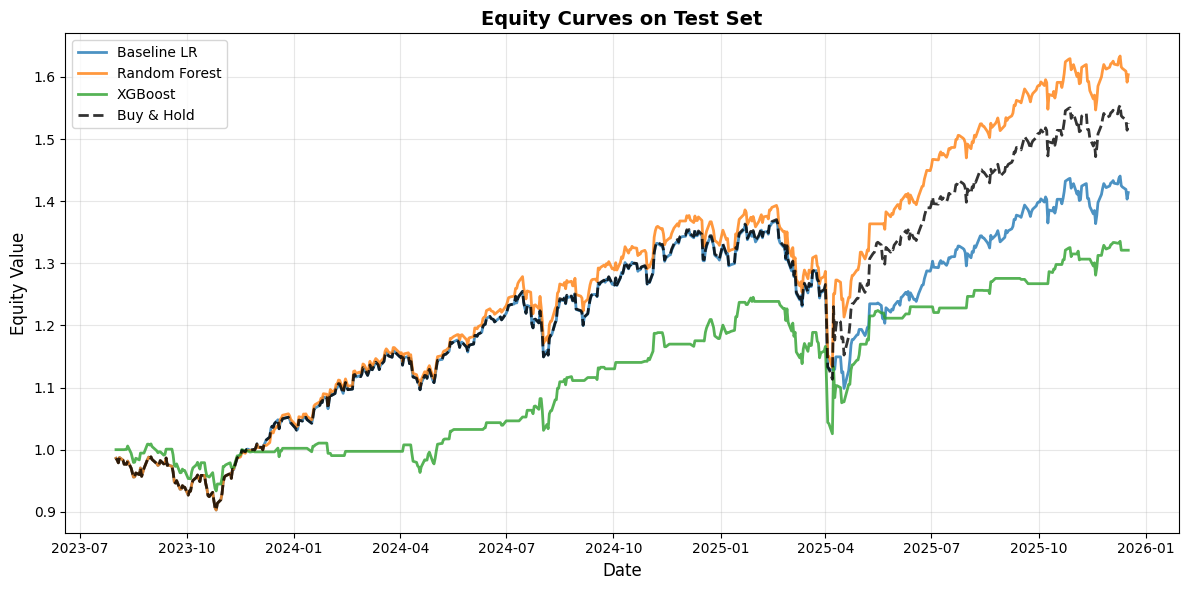

In [96]:
# Compute equity curves
eq_lr = compute_equity_curve(strategy_ret_lr)
eq_rf = compute_equity_curve(strategy_ret_rf)
eq_xgb = compute_equity_curve(strategy_ret_xgb)
eq_bh = compute_equity_curve(benchmark_ret)

# Plot equity curves
fig = plt.figure(figsize=(12, 6))
plt.plot(eq_lr.index, eq_lr.values, label='Baseline LR', linewidth=2, alpha=0.8)
plt.plot(eq_rf.index, eq_rf.values, label='Random Forest', linewidth=2, alpha=0.8)
plt.plot(eq_xgb.index, eq_xgb.values, label='XGBoost', linewidth=2, alpha=0.8)
plt.plot(eq_bh.index, eq_bh.values, label='Buy & Hold', linewidth=2, alpha=0.8, linestyle='--', color='black')

plt.title('Equity Curves on Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Equity Value', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure before showing
from pathlib import Path
out_dir = Path('..') / 'figures'
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'equity_curves_test.png'
fig.savefig(out_path, dpi=200, bbox_inches='tight')
print(f"✓ Equity curves saved to: {out_path}")

plt.show()

In [97]:
# Compute trading metrics for all strategies
strategies = {
    'Baseline LR': (strategy_ret_lr, eq_lr),
    'Random Forest': (strategy_ret_rf, eq_rf),
    'XGBoost': (strategy_ret_xgb, eq_xgb),
    'Buy & Hold': (benchmark_ret, eq_bh)
}

trading_metrics = []
for name, (returns, equity) in strategies.items():
    metrics = {
        'Strategy': name,
        'Cumulative Return': equity.iloc[-1] - 1,
        'Sharpe Ratio': compute_sharpe_ratio(returns),
        'Max Drawdown': compute_max_drawdown(equity)
    }
    trading_metrics.append(metrics)

trading_metrics_df = pd.DataFrame(trading_metrics).set_index('Strategy')

print("\n" + "="*70)
print("TRADING PERFORMANCE METRICS (Test Set)")
print("="*70)
print(trading_metrics_df.round(4))
print("="*70)
print("\nNote: Strategies are long-only with 0.5 probability threshold.")
print("No transaction costs or slippage included.")


TRADING PERFORMANCE METRICS (Test Set)
               Cumulative Return  Sharpe Ratio  Max Drawdown
Strategy                                                    
Baseline LR               0.4138        1.1207       -0.1970
Random Forest             0.6035        1.3695       -0.1876
XGBoost                   0.3210        0.9473       -0.1764
Buy & Hold                0.5256        1.2040       -0.1876

Note: Strategies are long-only with 0.5 probability threshold.
No transaction costs or slippage included.


In [98]:
# Save trading performance metrics to CSV
os.makedirs('../results', exist_ok=True)
trading_metrics_df.to_csv('../results/trading_metrics.csv')
print("\n✓ Trading metrics saved to results/trading_metrics.csv")


✓ Trading metrics saved to results/trading_metrics.csv


### Analysis and Recommendations

**Key observations:**

1. **Best validation performance**: Check which model has the highest ROC-AUC on validation set
2. **Test set generalization**: Compare validation vs test performance to assess robustness
3. **Overfitting indicators**: Large gaps between train and validation/test performance suggest overfitting
4. **Ensemble benefit**: Does the ensemble improve over individual models?

**For trading applications:**
- ROC-AUC is most important (captures ranking quality for position sizing)
- Precision matters for limiting false positive signals (bad trades)
- Recall matters for capturing profitable opportunities

**Next steps:**
- Consider feature importance analysis
- Tune decision threshold for precision/recall trade-off
- Implement walk-forward validation for production robustness

### Trading Performance Interpretation

**Key findings from test set trading simulation:**

1. **Best risk-adjusted performance**: Examine which strategy has the highest Sharpe ratio, balancing returns against volatility. Negative or near-zero Sharpe ratios indicate poor risk-adjusted returns.

2. **Drawdown comparison**: Models with smaller maximum drawdowns preserve capital better during adverse market conditions. Compare strategy drawdowns to buy-and-hold to assess downside protection.

3. **Cumulative returns**: While cumulative returns show total gain, they don't account for risk. A strategy with lower returns but higher Sharpe may be preferable for risk-adjusted performance.

4. **Overfitting evidence**: If a model showed strong validation performance but weak test trading metrics, this confirms overfitting - the model learned patterns that don't generalize to unseen data.

5. **Strategy limitations**: This simple long-only approach (predict up = buy, predict down = cash) ignores:
   - Transaction costs (can erode returns significantly with frequent trading)
   - Position sizing (binary in/out vs. scaled positions)
   - Short positions (can't profit from down predictions)
   - Market regime changes (models trained on bull markets may fail in bear markets)

**Practical implications**: For real trading, consider ensemble predictions, dynamic thresholds, position sizing based on prediction confidence, and robust walk-forward validation.